In [25]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

from autograd.nn import MLP
from autograd.core import tensor


### Basic usage

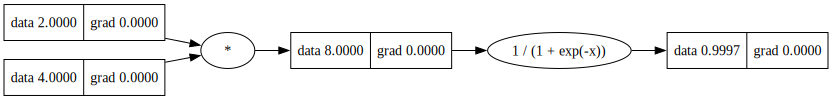

In [12]:
a = tensor(2.0)
b = tensor(4.0)

c = a * b

d = c.sigmoid()

d.visualize_tensor()

In [13]:
d.backward()

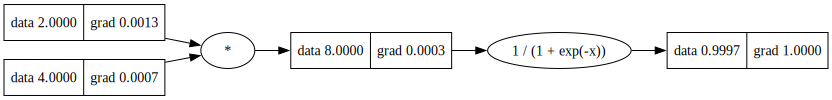

In [14]:
d.visualize_tensor()

### MLP usage

In [29]:
# Helper functions
def read_csv_to_label_and_feature_lists(file_path):
    labels = []
    features = []
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip the header
        for row in reader:
            if row:  # Check if the row is not empty
                label = float(row[0])
                x1, x2 = float(row[1]), float(row[2])
                
                # Convert label to one-hot encoding
                if label == 0.0:
                    labels.append([tensor(1.0), tensor(0.0)])
                elif label == 1.0:
                    labels.append([tensor(0.0), tensor(1.0)])
                
                # Append features
                features.append([tensor(x1), tensor(x2)])
    
    return labels, features

def scatter_plot(X, y, plot_title="Scatter Plot of Data Points"):
    """
    Creates a scatter plot of the data points with different colors for each class.

    Args:
        X (np.array): 2D array of shape (n_samples, n_features), where each row is a data point.
        y (list of lists or np.array): One-hot encoded class labels (2D array or list of lists).
        plot_title (str): The title of the plot.
    """
    # Convert y to a numpy array if it's a list of lists
    if isinstance(y, list):
        y = np.array(y)
    
    # Ensure that y has one-hot encoding (for binary classification, this will be 2)
    class_0 = [i for i, label in enumerate(y) if label[0] == 1.0]  # Class 0
    class_1 = [i for i, label in enumerate(y) if label[1] == 1.0]  # Class 1
    
    # Create scatter plot for class 0 and class 1
    plt.scatter(X[class_0, 0], X[class_0, 1], color='red', label="Class 0")
    plt.scatter(X[class_1, 0], X[class_1, 1], color='blue', label="Class 1")
    
    # Labels and title
    plt.title(plot_title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Helper function to compute the predictions from the model for plotting
def predict(model, x):
    """Given a trained model and input features, return the predicted class."""
    # Forward pass through the network
    output = model(x)
    output_scores = [t.data for t in output]  # Extracting the 'data' from tensor objects
    return output_scores

def plot_decision_boundary(model, X, y, plot_title="Decision Boundary"):
    """Plots decision boundary and data points."""
    h = 0.1  # Resolution of the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a grid of points with step size h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict over the grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = [predict(model, [tensor(x[0]), tensor(x[1])]) for x in grid_points]
    predictions = np.array([np.argmax(p) for p in predictions])  # Get the predicted class index
    
    # Reshape predictions to match the grid shape
    zz = predictions.reshape(xx.shape)

    # Plot decision surface
    plt.contourf(xx, yy, zz, alpha=0.5, cmap=plt.cm.coolwarm)
    
    # Scatter plot of the original data points
    class_0 = [i for i, label in enumerate(y) if label[0] == 1.0]  # Class 0 (first element is 1 for class 0)
    class_1 = [i for i, label in enumerate(y) if label[1] == 1.0]  # Class 1 (second element is 1 for class 1)

    plt.scatter(X[class_0, 0], X[class_0, 1], color='blue', label="Class 0")
    plt.scatter(X[class_1, 0], X[class_1, 1], color='red', label="Class 1")
    
    # Title and labels
    plt.title(plot_title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

def argmax(data_list):
    max_index = 0
    max_value = data_list[0]
    for i, value in enumerate(data_list):
        if value > max_value:
            max_value = value
            max_index = i
    return max_index

def compute_accuracy(model, features, labels):
    """
    Computes the accuracy of the model on the given features and labels.
    """
    correct = 0
    total = len(features)
    
    # Perform a forward pass for each feature set
    predictions = [model(feature) for feature in features]
    
    for pred, true in zip(predictions, labels):
        # Extract data from prediction and label tensors
        pred_scores = [t.data for t in pred]
        true_scores = [t.data for t in true]
        
        # Determine predicted and true classes using argmax
        predicted_class = argmax(pred_scores)
        true_class = argmax(true_scores)
        
        # Compare and count correct predictions
        if predicted_class == true_class:
            correct += 1
    
    accuracy = (correct / total) * 100  # Convert to percentage
    return accuracy

def mean_squared_error(y_pred, y_true):
    loss = []
    for pred_sample, true_sample in zip(y_pred, y_true):
        assert len(pred_sample) == len(true_sample), "y_pred and y_true must have the same length"
        mse = (sum((yi - yi_true) ** 2 for yi, yi_true in zip(pred_sample, true_sample))) / len(pred_sample)
        loss.append(mse)
    return loss

def multiclass_cross_entropy(y_pred, y_true):
    loss = []
    for pred_sample, true_sample in zip(y_pred, y_true):
        assert len(pred_sample) == len(true_sample), "y_pred and y_true must have the same length"
        mce = -sum(yi_true * math.log(max(yi.data, 1e-10)) for yi, yi_true in zip(pred_sample, true_sample))
        loss.append(tensor(mce))
    return loss

In [30]:
file_path = 'xor_train.csv'
train_labels, train_features = read_csv_to_label_and_feature_lists(file_path)

In [31]:
lr = 0.01
epochs = 100
model = MLP(2, [7, 2], 'Tanh')

# the training loop
for epoch in range(epochs):
    # forward pass
    output = [model(x) for x in train_features]
    total_loss = mean_squared_error(output, train_labels)
    
    # backward pass
    model.zero_grad()
    for loss in total_loss:
        loss.backward()

    # update
    for p in model.parameters():
        p.data += (-lr) * p.grad

    # print loss every 100 epochs
    if epoch % 10 == 0:
        average_loss = sum(loss.data for loss in total_loss) / len(total_loss)
        print(f"Epoch {epoch}, Loss: {average_loss:.4f}")
    

Epoch 0, Loss: 0.5159
Epoch 10, Loss: 0.4227
Epoch 20, Loss: 0.4454
Epoch 30, Loss: 0.3665
Epoch 40, Loss: 0.3443
Epoch 50, Loss: 0.1753
Epoch 60, Loss: 0.1187
Epoch 70, Loss: 0.1251
Epoch 80, Loss: 0.1347
Epoch 90, Loss: 0.1156


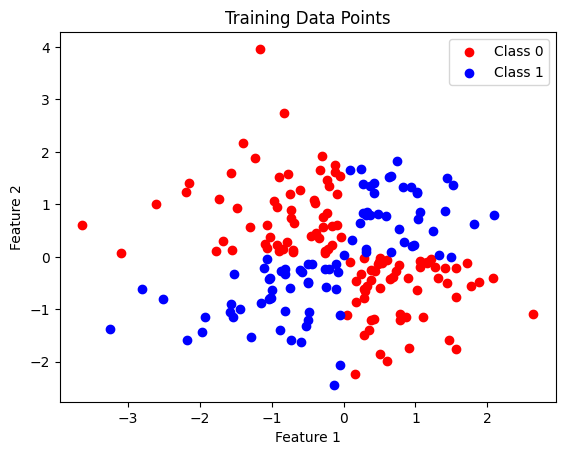

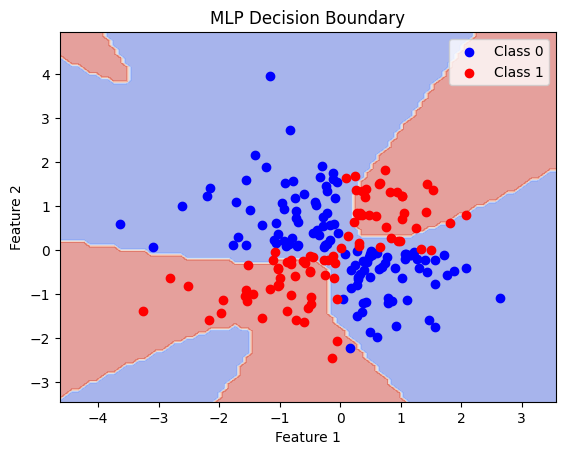

In [32]:
train_features_np = np.array([[x[0].data, x[1].data] for x in train_features])
train_labels_np = np.array([[l[0].data, l[1].data] for l in train_labels])

scatter_plot(train_features_np, train_labels_np, plot_title="Training Data Points")
plot_decision_boundary(model, train_features_np, train_labels_np, plot_title="MLP Decision Boundary")

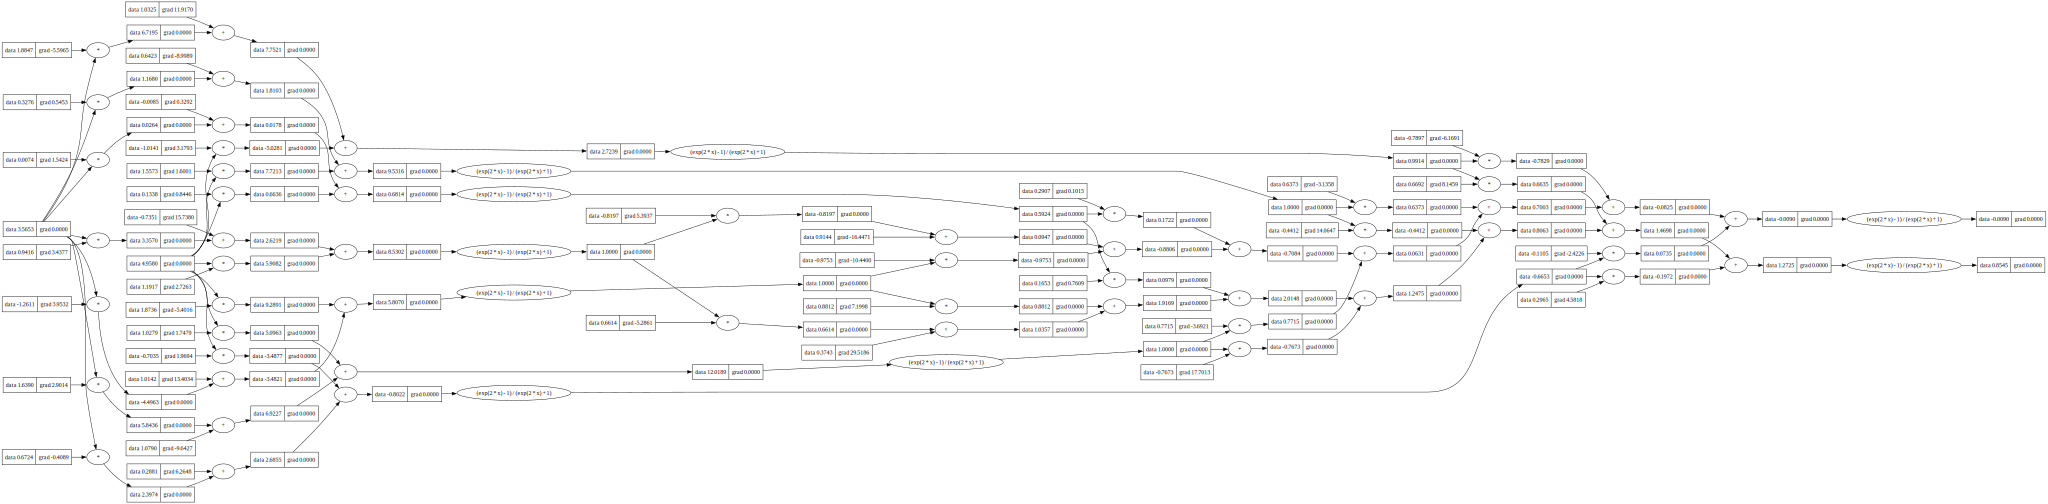

In [33]:
model.visualize()